## Hierarchical Modeling Example - Radon Testing

Gelman and Hill, 2006
Code adapted by D.E. Brown from The PyMC Development Team, 2018, 
https://docs.pymc.io/notebooks/multilevel_modeling.html

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-darkgrid')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set ransom seed
np.random.seed(22904)

In [3]:
# Import radon data
srrs2 = pd.read_csv(pm.get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()

In [4]:
#county-level predictor - combining two variables

srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [5]:
# Combine home- and county-level information in a single DataFrame

srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

In [6]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [7]:
# The variables

srrs_mn.columns

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm'],
      dtype='object')

In [8]:
# lookup table (dict) for each county

srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

In [9]:
# local copies of variables

county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

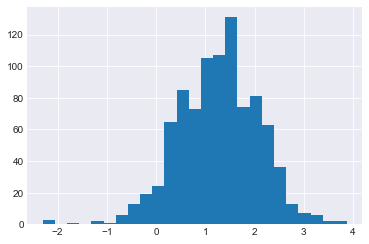

In [10]:
# Histogram of radon levels

srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25);

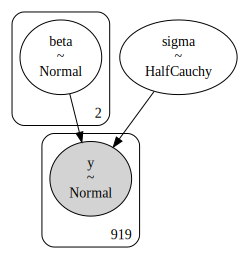

In [11]:
# Complete pooling model
# All counties are contributors to the data and then ignored to produce one statewide model
# This model uses only the intercept and the floor (this is binary to show basement or not)

floor = srrs_mn.floor.values
log_radon = srrs_mn.log_radon.values

with Model() as pooled_model:
    beta = pm.Normal('beta', 0, sd=1e5, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)

    theta = beta[0] + beta[1]*floor

    y = pm.Normal('y', theta, sd=sigma, observed=log_radon)
pm.model_to_graphviz(pooled_model)

In [20]:
with pooled_model:
    pooled_trace = pm.sample(1000, cores = 4, tune=1000)
    pooled_idata = az.from_pymc3(pooled_trace)
az.summary(pooled_idata, round_to=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],1.36,0.03,1.31,1.41,0.0,0.0,3703.26,3703.26,3706.83,2590.82,1.0
beta[1],-0.59,0.07,-0.71,-0.44,0.0,0.0,3502.58,3430.10,3493.89,2771.12,1.0
sigma,0.79,0.02,0.76,0.83,0.0,0.0,4285.25,4284.40,4286.68,2600.88,1.0


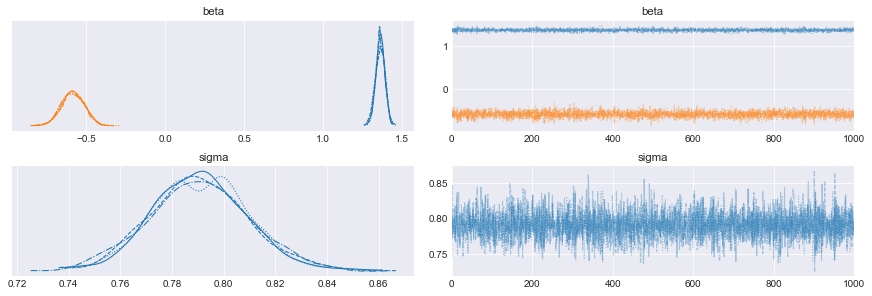

In [22]:
with pooled_model:
    pm.traceplot(pooled_trace)

In [23]:
b0, m0 = pooled_trace['beta'].mean(axis=0)

Text(0, 0.5, 'Log(Radon)')

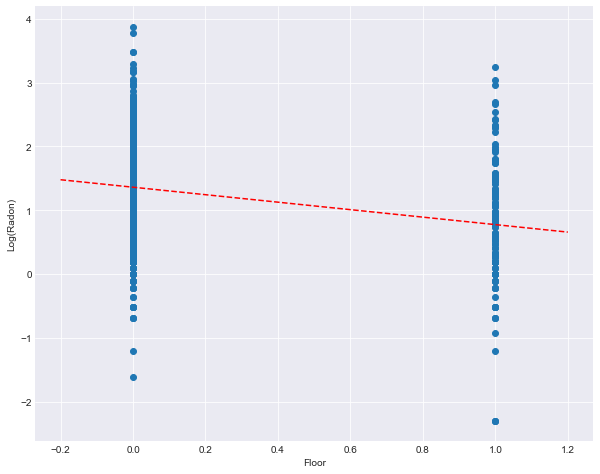

In [29]:
# Plot of the pooled model

plt.figure(figsize = (10,8))
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--');
plt.xlabel("Floor")
plt.ylabel("Log(Radon)")

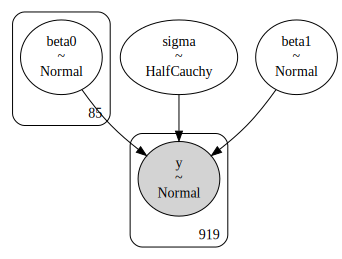

In [12]:
# Unpooled Model

with Model() as unpooled_model:

    beta0 = pm.Normal('beta0', 0, sd=1e5, shape=counties)
    beta1 = pm.Normal('beta1', 0, sd=1e5)
    sigma = pm.HalfCauchy('sigma', 5) # Half cauchy, 
                                      # becuase variance must be greater than 0

    theta = beta0[county] + beta1*floor

    y = pm.Normal('y', theta, sd=sigma, observed=log_radon)
pm.model_to_graphviz(unpooled_model)

In [31]:
with unpooled_model:
    unpooled_trace = pm.sample(1000, cores = 4, tune=1000)
    unpooled_idata = az.from_pymc3(unpooled_trace)
az.summary(pooled_idata, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],1.36,0.03,1.31,1.41,0.0,0.0,3703.26,3703.26,3706.83,2590.82,1.0
beta[1],-0.59,0.07,-0.71,-0.44,0.0,0.0,3502.58,3430.10,3493.89,2771.12,1.0
sigma,0.79,0.02,0.76,0.83,0.0,0.0,4285.25,4284.40,4286.68,2600.88,1.0


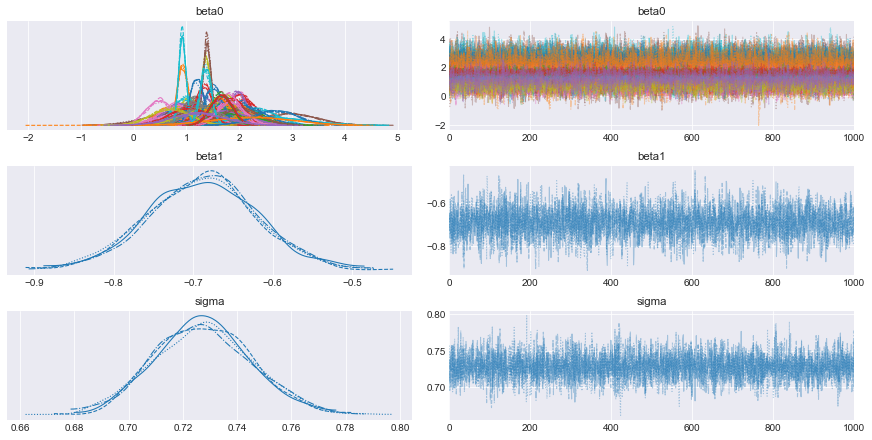

In [64]:
with unpooled_model:
    pm.traceplot(unpooled_trace)

/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<Figure size 432x1008 with 0 Axes>

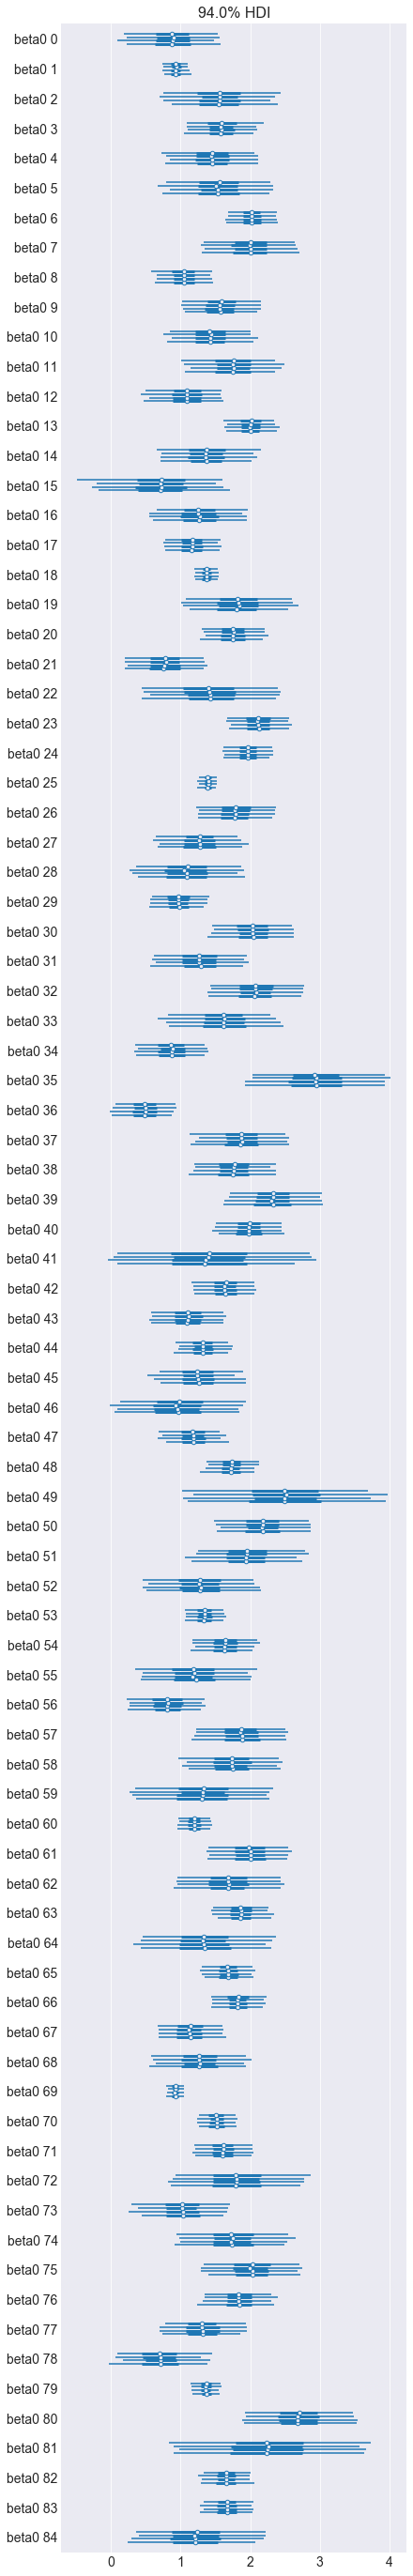

In [32]:
# County parameters
plt.figure(figsize=(6,14))
pm.forestplot(unpooled_trace, varnames=['beta0']);

In [33]:
# Unpooled estimates

unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=mn_counties)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=mn_counties)

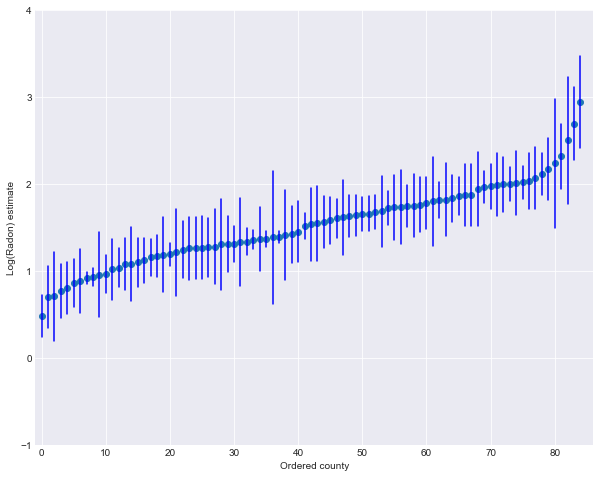

In [36]:
# Plot of the unpooled estimates

order = unpooled_estimates.sort_values().index

plt.figure(figsize = (10,8))
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Log(Radon) estimate');plt.xlabel('Ordered county');

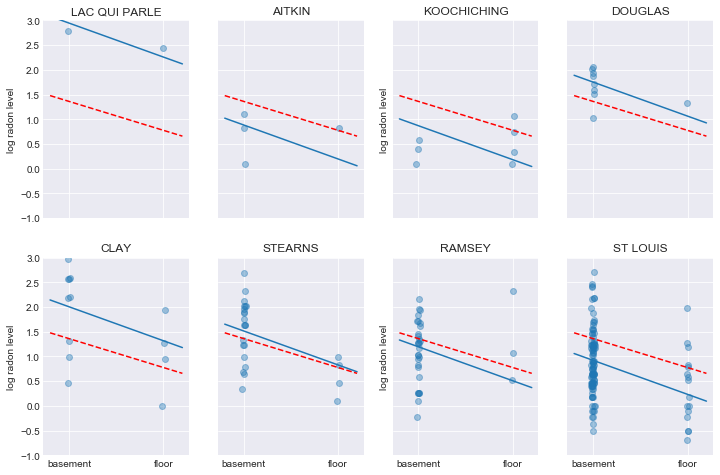

In [38]:
# Plot of pooled and unpooled estimates for some counties

sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING',
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 8), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_estimates[c]

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

## Partial Pooling Model

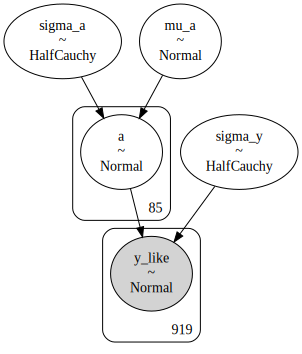

In [13]:
with Model() as partial_pooling:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=counties)

    # Model error
    sigma_y = pm.HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a[county]

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

pm.model_to_graphviz(partial_pooling)

In [41]:
with partial_pooling:
    partial_pooling_trace = pm.sample(2000, cores = 4, tune=1000)
    partial_pooled_idata = az.from_pymc3(partial_pooling_trace)
az.summary(partial_pooled_idata, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, a, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,1.35,0.05,1.26,1.44,0.0,0.0,4865.96,4862.89,4865.88,5855.20,1.0
a[0],1.11,0.24,0.67,1.58,0.0,0.0,9327.99,9054.19,9314.53,6021.07,1.0
a[1],0.94,0.10,0.76,1.14,0.0,0.0,10146.41,9906.69,10171.45,5246.83,1.0
a[2],1.27,0.25,0.78,1.75,0.0,0.0,12187.16,11912.56,12199.40,6047.38,1.0
a[3],1.27,0.21,0.86,1.66,0.0,0.0,10212.50,10134.35,10230.82,5655.08,1.0
a[4],1.32,0.24,0.85,1.76,0.0,0.0,11642.17,11360.23,11612.58,5532.35,1.0
a[5],1.41,0.26,0.92,1.87,0.0,0.0,10400.41,9756.40,10431.79,5519.01,1.0
a[6],1.74,0.17,1.43,2.09,0.0,0.0,7420.11,7420.11,7441.82,5776.97,1.0
a[7],1.46,0.24,0.99,1.91,0.0,0.0,12521.36,11922.21,12513.12,5680.44,1.0
a[8],1.12,0.19,0.77,1.49,0.0,0.0,11616.42,11616.42,11664.73,5574.36,1.0


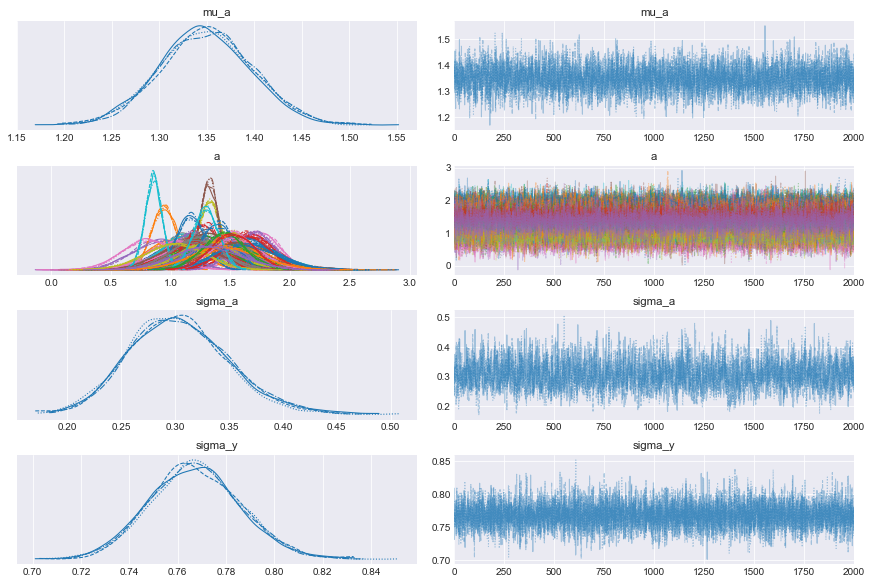

In [65]:
with partial_pooling:
    pm.traceplot(partial_pooling_trace)

<Figure size 432x1296 with 0 Axes>

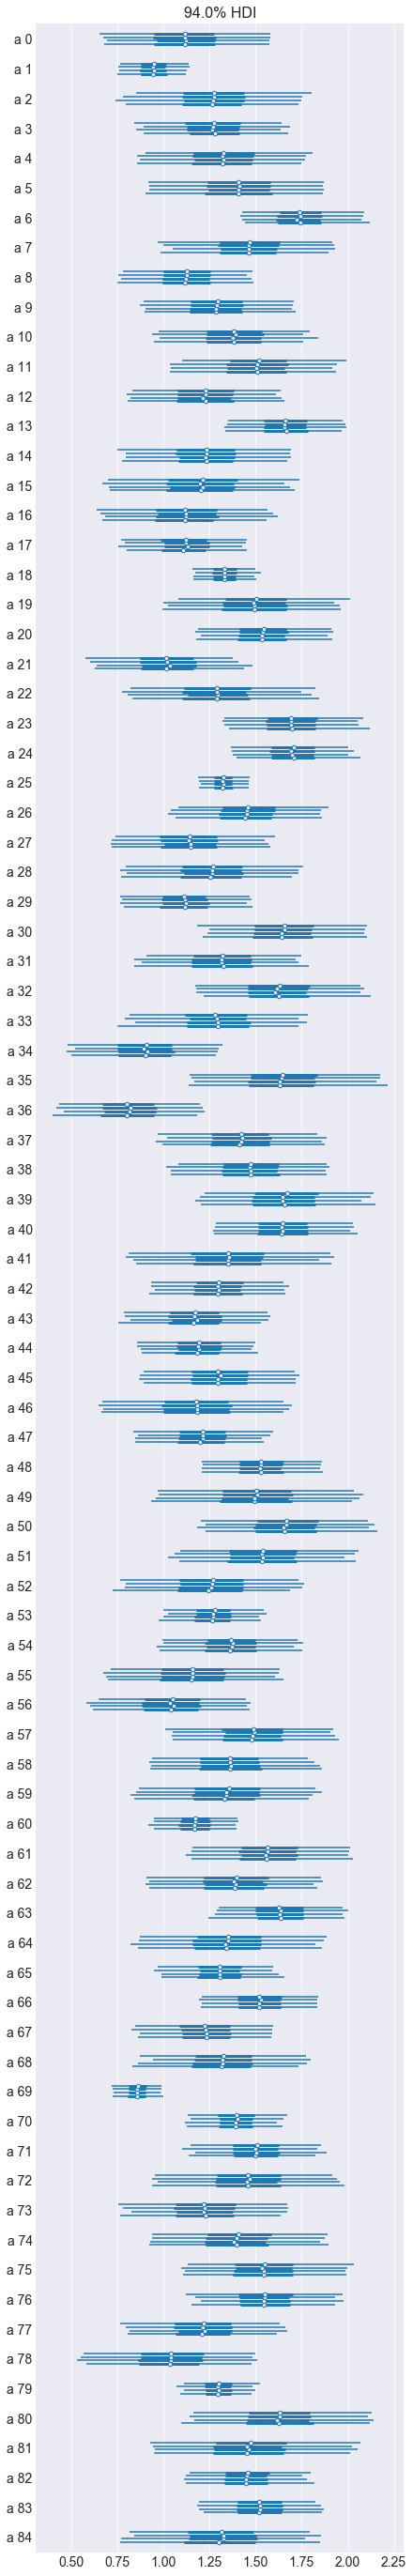

In [63]:
# parameter plots

with partial_pooling:
    plt.figure(figsize=(6,18))
    pm.forestplot(partial_pooling_trace, var_names=['a']);

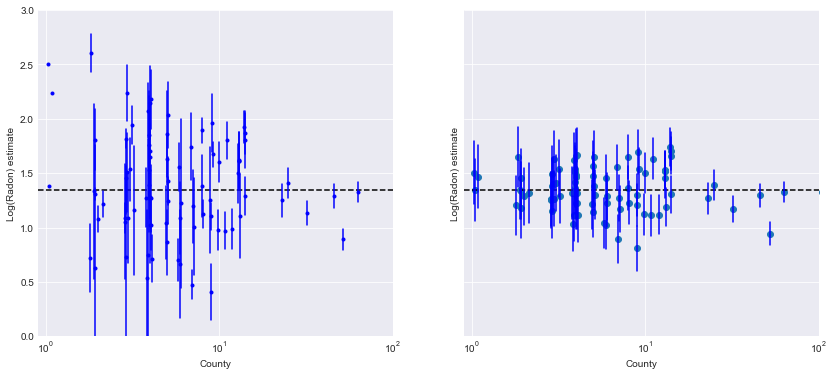

In [50]:
sample_trace = partial_pooling_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=counties)

n_county = srrs_mn.groupby('county')['idnum'].count()
unpooled_means = srrs_mn.groupby('county')['log_radon'].mean()
unpooled_sd = srrs_mn.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
axes[0].set_ylabel("Log(Radon) estimate")
axes[0].set_xlabel("County")


samples, counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(0.9,100)
axes[1].set_ylim(0, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
axes[1].set_ylabel("Log(Radon) estimate")
axes[1].set_xlabel("County")

for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

# Hierarchical Model
## Varying intercept and slope model

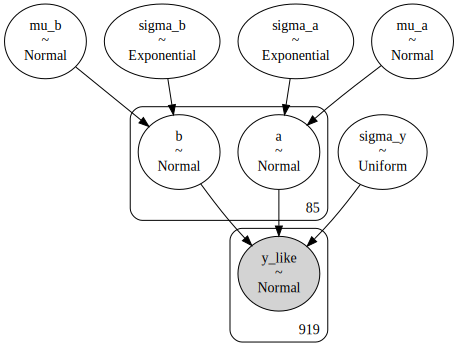

In [14]:
with Model() as varying_intercept_slope:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    #sigma_b =  pm.HalfCauchy('sigma_b', 10)
    sigma_b = pm.Exponential("sigma_b", .5)

    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=counties)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=counties)

    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a[county] + b[county] * floor_measure

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

pm.model_to_graphviz(varying_intercept_slope)

In [94]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(5000, step = pm.NUTS(target_accept = 0.99), cores = 4, tune=5000)
    varying_intercept_slope_idata = az.from_pymc3(varying_intercept_slope_trace)
az.summary(varying_intercept_slope_idata, round_to=2)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 163 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9707765697433671, but should be close to 0.99. Try to increase the number of tuning steps.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9076744828109229, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,1.49,0.05,1.40,1.59,0.00,0.00,8043.36,8043.36,8005.20,9741.86,1.00
mu_b,-0.65,0.08,-0.80,-0.49,0.00,0.00,3439.90,3439.90,3444.06,6306.17,1.00
a[0],1.22,0.24,0.77,1.69,0.00,0.00,25763.67,25508.81,25875.86,13656.99,1.00
a[1],0.99,0.10,0.80,1.17,0.00,0.00,22436.37,22102.22,22504.87,14182.24,1.00
a[2],1.50,0.26,1.01,2.00,0.00,0.00,21539.40,21539.40,21478.87,11839.67,1.00
a[3],1.54,0.22,1.13,1.96,0.00,0.00,19708.19,19673.73,19686.98,14269.69,1.00
a[4],1.47,0.24,1.00,1.92,0.00,0.00,22089.74,20928.59,22073.71,11470.63,1.00
a[5],1.51,0.26,1.04,1.99,0.00,0.00,29990.98,28397.09,29951.06,13145.07,1.00
a[6],1.86,0.17,1.52,2.16,0.00,0.00,11600.23,10289.41,12296.40,6759.41,1.00
a[7],1.70,0.25,1.21,2.16,0.00,0.00,25020.75,24714.50,24953.74,14781.24,1.00


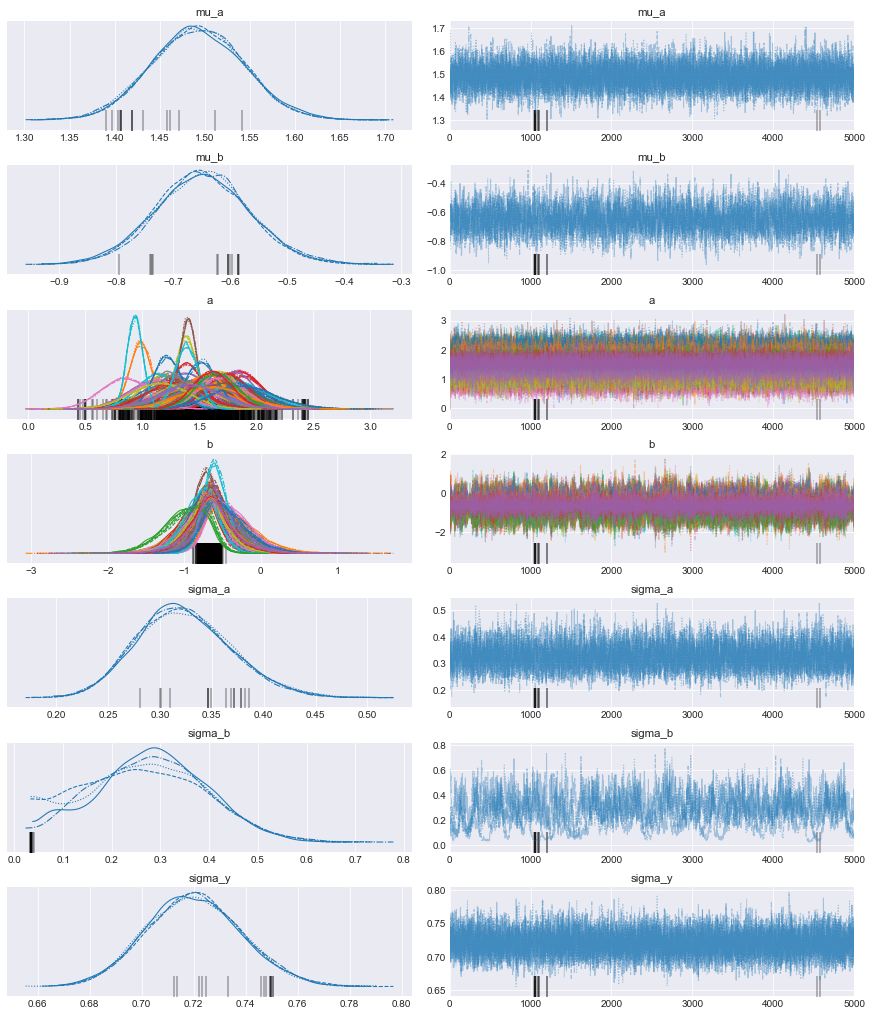

In [84]:
with varying_intercept_slope:
    pm.traceplot(varying_intercept_slope_trace)

<Figure size 432x1296 with 0 Axes>

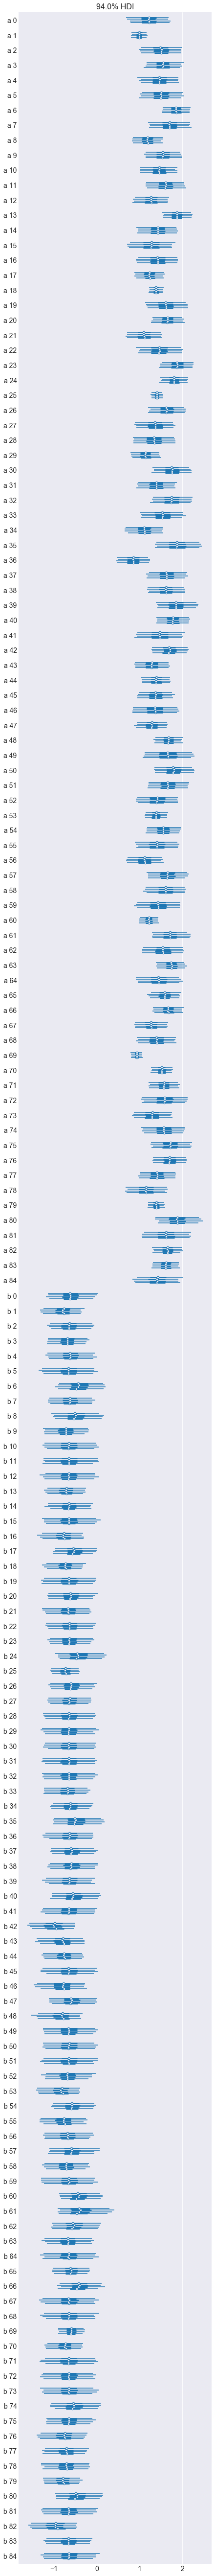

In [59]:
# parameter plots

with varying_intercept_slope:
    plt.figure(figsize=(6,18))
    pm.forestplot(varying_intercept_slope_trace, var_names=['a','b']);

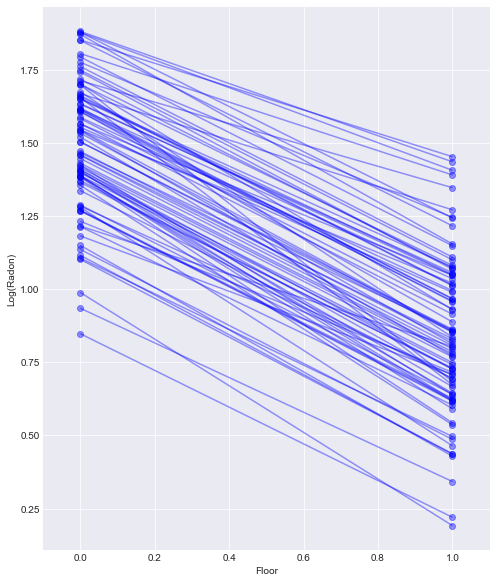

In [62]:
# County predictions

xvals = np.arange(2)
b = varying_intercept_slope_trace['a'].mean(axis=0)
m = varying_intercept_slope_trace['b'].mean(axis=0)
plt.figure(figsize = (8,10))
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1)
plt.xlabel("Floor")
plt.ylabel("Log(Radon)");